## 다중공선성(multicollinearity)

어떤 실수 행렬 $X$ 에 대해 $X^TX$ 형태인 정방행렬을 분산행렬(scatter matrix)라고 한다.

이 때 분산행렬이 풀랭크라면 분산행렬 $X^TX$의 역행렬이 존재하여 선형연립방정식의 해(계수)를 구할 수 있다.

In [71]:
X = np.array([[1, 2],
             [3, 4],
             [5, 6]])

y = np.array([[100],
             [200]])

In [72]:
X.T @ X

array([[35, 44],
       [44, 56]])

In [73]:
# 풀랭크 확인

np.linalg.matrix_rank(X.T @ X)

2

In [74]:
# 계수값 계산

w = np.linalg.inv(X.T@X) @ y
w

array([[-133.33333333],
       [ 108.33333333]])

In [75]:
# 계수값을 이용한 y값 계산

(X.T @ X) @ w

array([[100.],
       [200.]])

하지만 풀랭크가 아닌 경우, 즉 독립변수들이 0이 아닌 어떤 스칼라의 선형 조합으로 영벡터 또는 0이 되는 경우(선형종속) 특징행렬 $X$가 풀랭크가 되어야 한다는 조건이 깨져 역행렬을 구할 수 없다. 만약 구해지더라도 그 오차가 매우 크게 발생한다.


In [76]:
# X 행렬의 마지막 열에 1열, 2열의 평균값을 추가

X = np.array([[1, 2, 1.5],
             [3, 4, 3.5],
             [5, 6, 5.5]])

y = np.array([[100],
             [200],
             [300]])

In [77]:
# 분산행렬은 3 * 3 행렬

X.T @ X

array([[35.  , 44.  , 39.5 ],
       [44.  , 56.  , 50.  ],
       [39.5 , 50.  , 44.75]])

In [78]:
# 3 * 3 행렬의 랭크가 2이므로 풀랭크가 아님

np.linalg.matrix_rank(X.T @ X)

2

In [79]:
# 모수값 계산 불가

np.linalg.inv(X.T @ X) @ y

LinAlgError: Singular matrix

# 미국 거시경제지표 예제

아래의 데이터는 statsmodels에서 제공하는 미국거시경제지표 데이터로 다중공선성이 무엇이고 회귀분석에 어떤 영향을 미치는지 확인하기 좋은 예제이다.

- TOTEMP - Total Employment

- GNPDEFL - GNP deflator

- GNP - GNP

- UNEMP - Number of unemployed

- ARMED - Size of armed forces

- POP - Population

- YEAR - Year (1947 - 1962)

미국거시경제지표 데이터를 seaborn의 pairplot을 통해 각 변수간의 상관관계를 scatter plot으로 확인하면 다음과 같다.

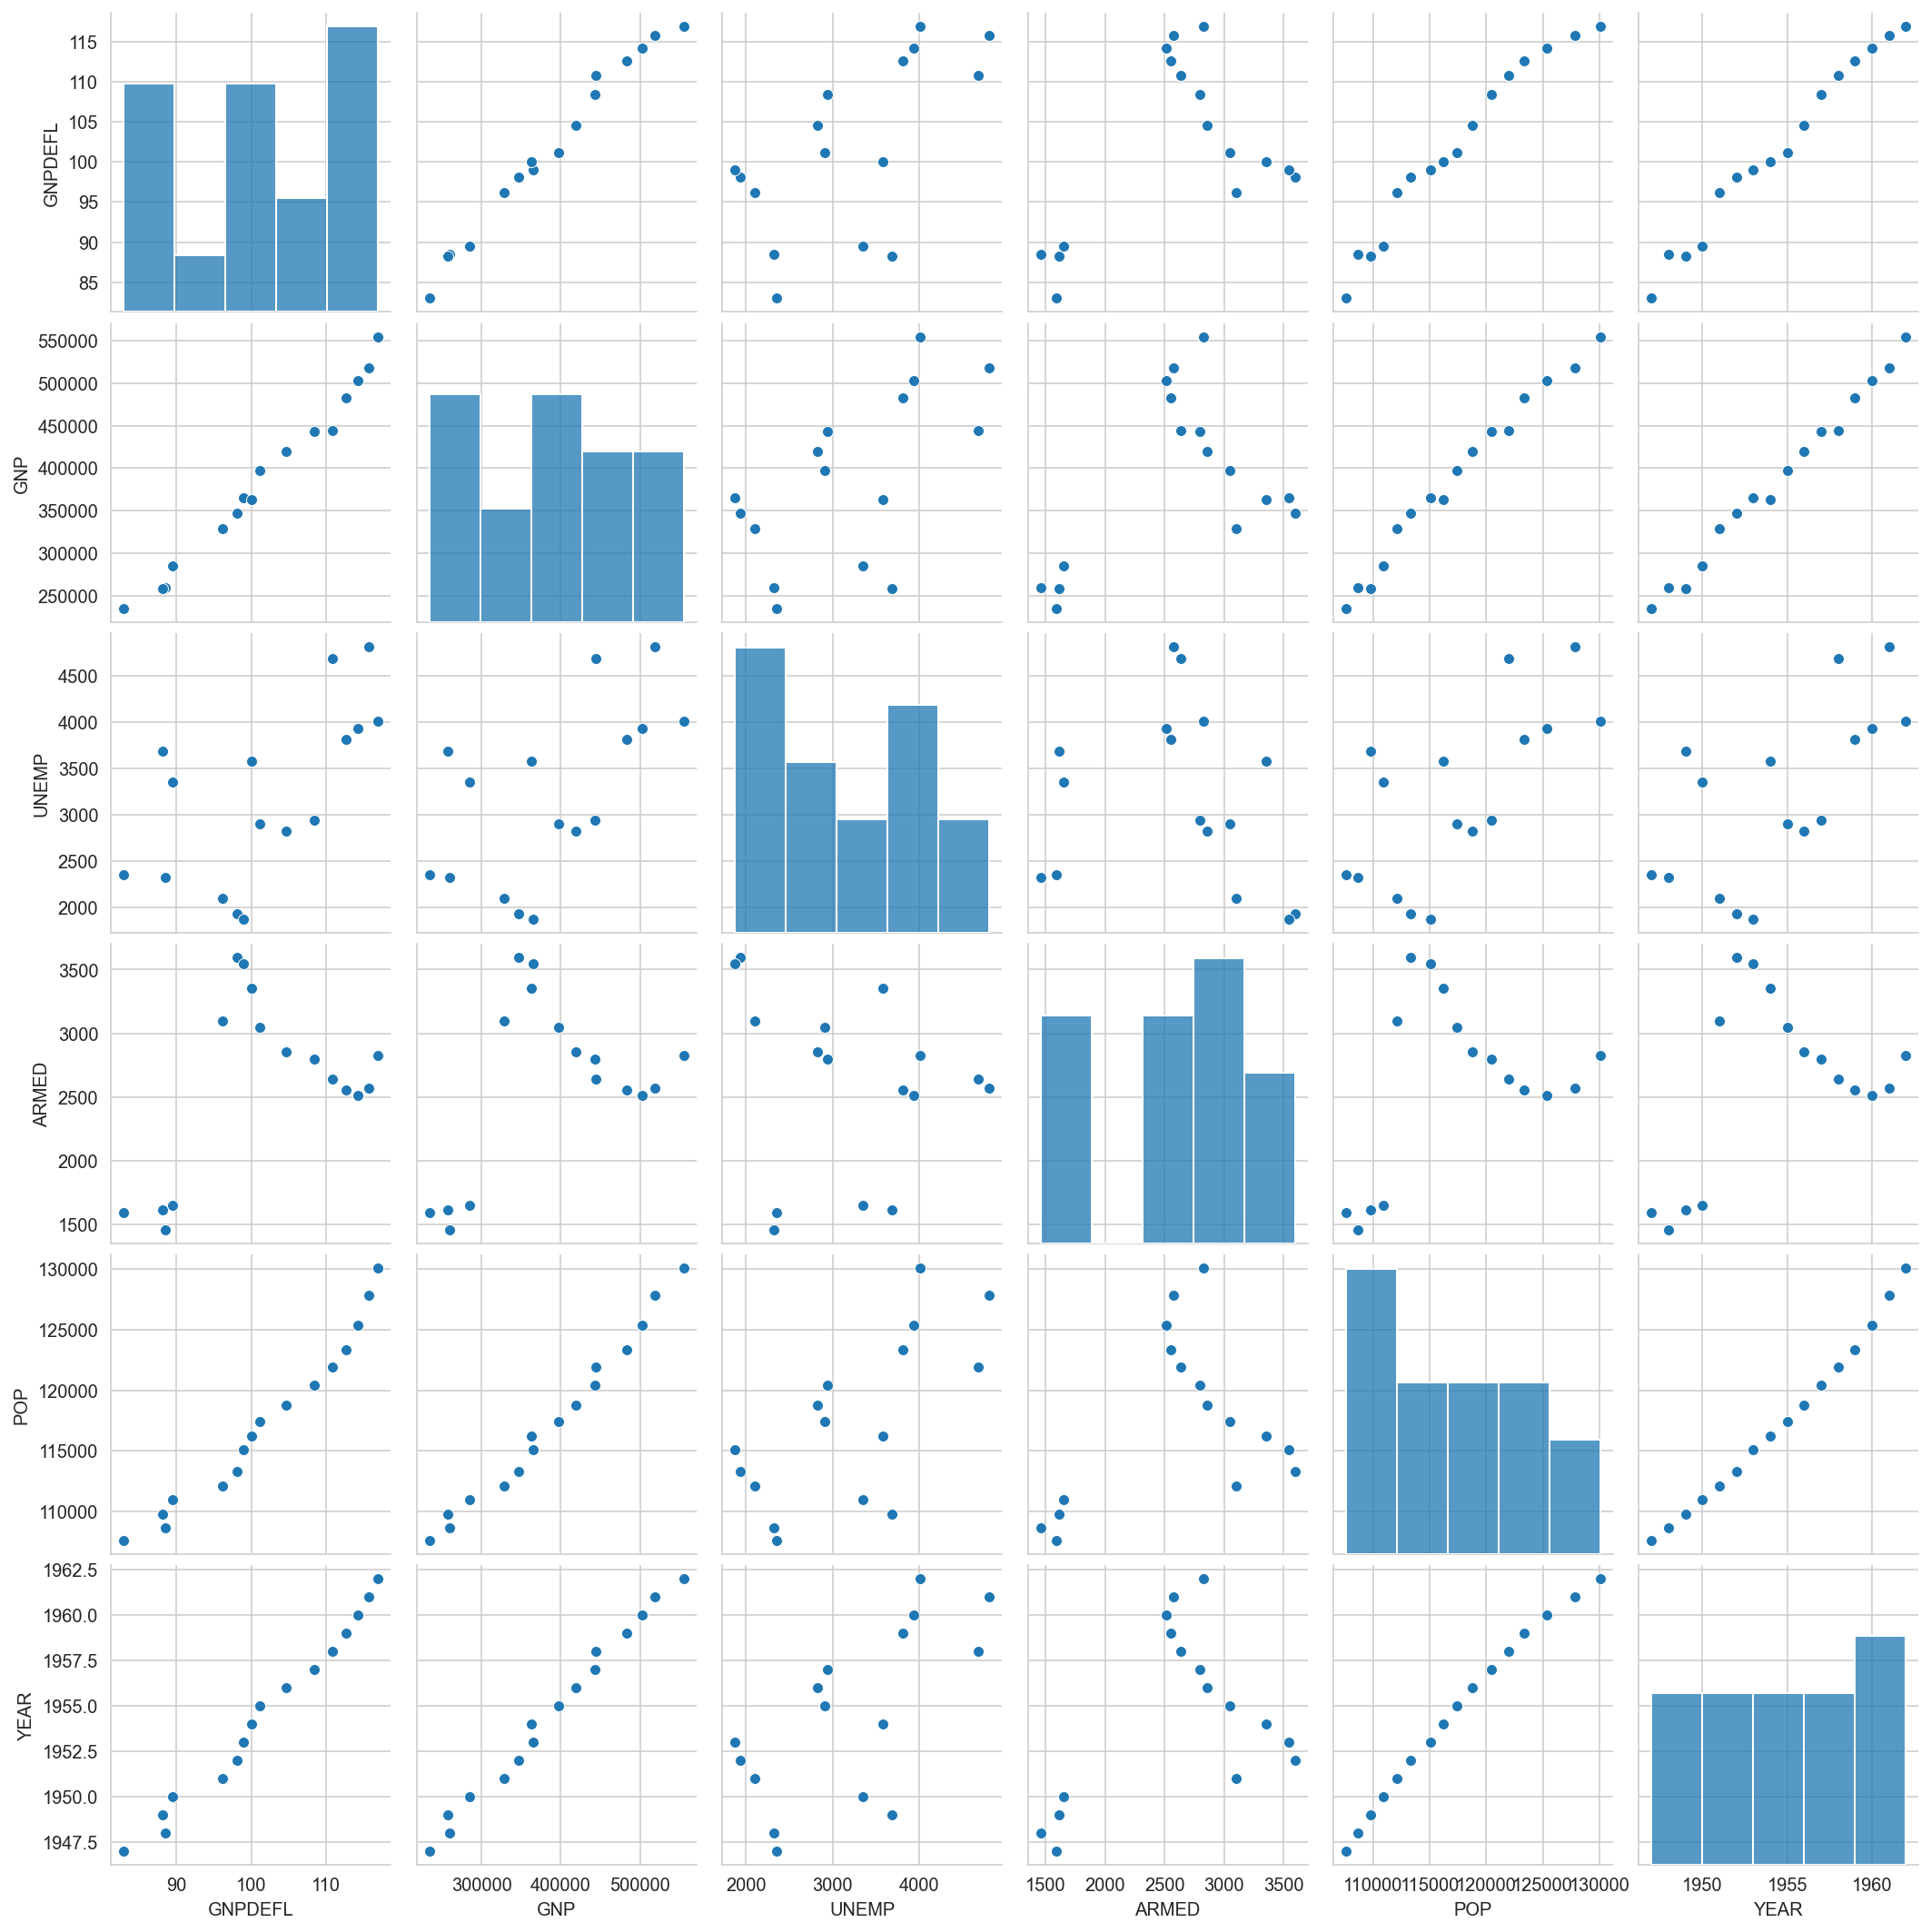

In [81]:
from statsmodels.datasets.longley import load_pandas
import statsmodels.api as sm

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

독립변수들의 pairplot임에도 불구하고 독립변수간에 매우 강한 상관관계를 갖는 변수들이 많은것을 한눈에 확인할 수 있다.

pandas의 `corr()` 메소드를 통해 상관계수 행렬을 확인할 수 있다.

In [82]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


이를 더 시각적으로 좋게 표현하려면 다음과 같이 heatmap 차트로도 확인 가능하다.

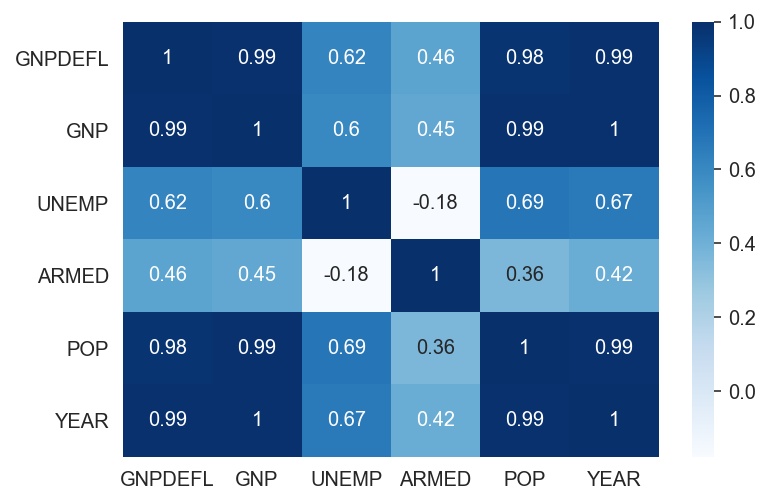

In [83]:
sns.heatmap(dfX.corr(), annot=True, cmap='Blues')
plt.show()

실제로 다중공선성이 발생하는 경우 아래와 같이 선형회귀 모델의 R-squared는 1이라는 값이 측정되지만 공분산 행렬의 조건수(condition number)가 200억으로 측정되어 warning이 발생한다. (일반적으로 10000만 넘어도 warning이 발생) 

In [84]:
from sklearn.model_selection import train_test_split

def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Fri, 27 Aug 2021   Prob (F-statistic):             0.0366
Time:                        12:54:37   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

위 OLS report의 결정계수와 조건수로 봤을 때 과적합이라고 의심할 수 있다. 따라서 아래의 코드를 이용해 train, test 데이터로 나누어 성능을 비교한 결과를 확인하면 과적합인 것을 확인할 수 있다.

In [85]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1

[0.9815050656855373,
 0.9738497543090551,
 0.987936636997055,
 0.7588861967893565,
 0.9807206089303887,
 0.893788931513089,
 0.8798563810579391,
 0.9314665778963518,
 0.8608525682162341,
 0.9677198735141291]

이처럼 독립변수가 서로 의존하는 다중공선성 문제가 발생하는 경우 과적합 문제가 발생하게 되는데 이는 회귀분석 모델의 성능의 안정성을 해칠 수 있다. 


따라서 아래의 방법을 이용해 과적합을 방지한다.

1. 변수선택법을 이용한 의존변수 제거

2. PCA 를 이용한 의존성분 제거

3. 정규화 방법

## VIF

VIF(Variance Inflation Factor)는 독립변수를 다른 독립변수들로 선형회귀한 성능을 말한다.

$$\text{VIF}_i = \frac{\sigma^2}{(n-1)\text{Var}[X_i]}\cdot \frac{1}{1-R_i^2}$$

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [98]:
vif.features.values

array(['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP', 'YEAR'], dtype=object)

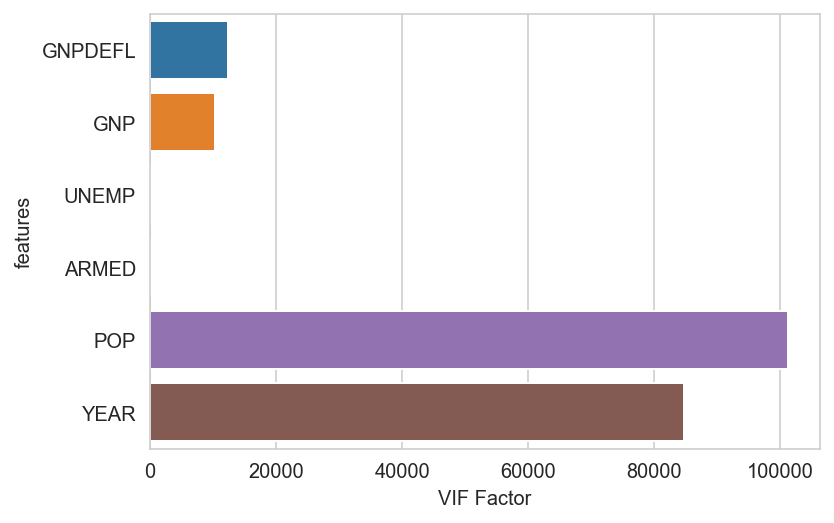

In [102]:
sns.barplot(data=vif, x='VIF Factor', y='features')
plt.show()

VIF를 통해 다른 변수에 의존적인 독립변수를 확인할 수 있으며 GNP, ARMED, UNEMP만을 이용해 회귀분석을 실시한 결과 다음과 같이 결정계수가 0.98로 확인된다.

In [89]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Fri, 27 Aug 2021   Prob (F-statistic):           0.000231
Time:                        12:57:49   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

warning에도 다중공선성에 대한 이야기가 없는 것으로 확인되고 교차검증 결과 또한 이전 모델보다 확실히 성능이 개선된 것을 확인할 수 있다.

In [103]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2

[0.9763608388904902,
 0.9841984331185697,
 0.9687069366140136,
 0.9397304053201785,
 0.9773357061188465,
 0.9561262155732307,
 0.9803852496698635,
 0.9917361722470805,
 0.9837134067639468,
 0.9789512977093214]

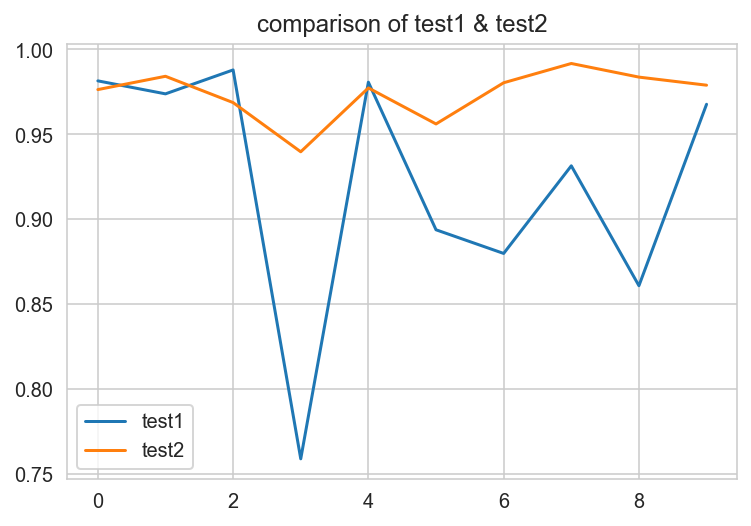

In [117]:
plt.title('comparison of test1 & test2')
plt.plot(test1, label='test1')
plt.plot(test2, label='test2')
plt.legend()
plt.show()